In [1]:
import datetime
import library_pool_data as lib_data
import pandas as pd
import numpy as np

def get_mav_pool_daily_asset_hold_and_trade_vol(date_begin_str='20230909', date_end_str = '20231208'):

    # contract_addr = CONST.MAV_POOL_ETH_SWETH

    # the code will directly load data from CSV files
    # df_to = get_contract_token_transfer_by_alchemy(contract_addr, date_end_str, date_begin_str, b_direction_to = True)
    # df_frm = get_contract_token_transfer_by_alchemy(contract_addr, date_end_str, date_begin_str, b_direction_to = False)

    df_to = pd.read_csv('output/token_txs_in_leg__0x0CE176E1b11A8f88a4Ba2535De80E81F88592bad.csv', index_col=0)
    df_frm = pd.read_csv('output/token_txs_out_leg__0x0CE176E1b11A8f88a4Ba2535De80E81F88592bad.csv',index_col=0)

    file_price_steth = "output/price_swETH_vs_eth.csv"
    df_seweth_price = pd.read_csv(file_price_steth)
    df_seweth_price['date_yyyymmdd'] = df_seweth_price['date_yyyymmdd'].astype(str)
    df_eth=df_seweth_price.copy()
    df_eth['token'] = 'WETH'
    df_eth['close_price'] = 1
    df_price = pd.concat([df_seweth_price, df_eth], ignore_index=True)

    # Merge DataFrames on the common columns
    merged_df = pd.merge(df_to, df_frm,  on=['block_number', 'date_yyyymmdd', 'hash'], how= 'inner') # outer
    df_vol = merged_df[ ['block_number', 'date_yyyymmdd','in_leg_asset',	'in_leg_asset_amt' ]].copy()
    df_vol.rename(columns={'in_leg_asset':'token', 'in_leg_asset_amt':'asset_amt'}, inplace=True)
    df_vol['date_yyyymmdd'] = df_vol['date_yyyymmdd'].astype(str)
    
    df_vol_price = pd.merge(df_vol, df_price,  on=[ 'date_yyyymmdd', 'token'], how= 'left') 
    df_vol_price['traded_amt_eth']=df_vol_price['asset_amt']*df_vol_price['close_price']

    summed_df = df_vol_price.groupby('date_yyyymmdd')['traded_amt_eth'].sum().reset_index()
    
    df_tvl = get_mav_pool_daily_TVL( date_begin_str=date_begin_str, date_end_str =date_end_str  )

    df = pd.merge(df_tvl,  summed_df,  on=['date_yyyymmdd'], how= 'left') # outer
    df.rename(columns={'close_price':'token_price_eth'}, inplace=True)
    df['staking_token'] = 'SWETH'
    df.sort_values(by='date', ascending=False, inplace=True)
    df['daily_turnover_rate'] = df['traded_amt_eth']/df['tvl_eth']
    df['daily_staking_rate'] = df['staking_asset_amt_eth']/df['tvl_eth']
    standard_col_names = ['date', 'block_number', 'pool_name', 'staking_token', 'token_price_eth', 'tvl_eth',  'staking_asset_amt_eth', 'daily_staking_rate','traded_amt_eth', 'daily_turnover_rate']
    return df[standard_col_names]


def get_mav_pool_daily_TVL(date_begin_str='20230801', date_end_str = '20231211'):

    df_dateblock = lib_data.get_date_and_blocknumber(date_begin_str, date_end_str )
    df_dateblock.set_index("block_number", inplace=True)

    file_weth_hold = "output/balanceof_wallet_0x0CE176E1b11A8f88a4Ba2535De80E81F88592baderc20_0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2.csv"
    df_weth = pd.read_csv(file_weth_hold)
    df_weth.set_index("block_number", inplace=True)
    df_weth.rename(columns={'token_balance':'WETH_balance'}, inplace=True)

    file_swETH_hold = "output/balanceof_wallet_0x0CE176E1b11A8f88a4Ba2535De80E81F88592baderc20_0xf951E335afb289353dc249e82926178EaC7DEd78.csv"
    df_swe = pd.read_csv(file_swETH_hold)
    df_swe.set_index("block_number", inplace=True)
    df_swe.rename(columns={'token_balance':'swETH_balance'}, inplace=True)

    file_price_steth = "output/price_swETH_vs_eth.csv"
    df_seweth_price = pd.read_csv(file_price_steth)

    #df_seweth_price.rename(columns={'close_price':'SWETH_price'}, inplace=True)
    df_seweth_price = df_seweth_price[['date_yyyymmdd', 'close_price']]
    
    df_seweth_price['date_yyyymmdd'] = df_seweth_price['date_yyyymmdd'].astype(str)


    df_block = pd.concat([df_dateblock, df_weth, df_swe], axis=1)
    df_block = df_block.reset_index()
    df_block.dropna(subset=['date_yyyymmdd'], inplace=True)
    df = pd.merge(df_block,df_seweth_price, on=['date_yyyymmdd'] , how = 'left')
    df['staking_asset_amt_eth'] = df['swETH_balance']*df['close_price']
    df['tvl_eth'] = df['staking_asset_amt_eth'] + df['WETH_balance']
    df['date'] = pd.to_datetime(df['date_yyyymmdd'], format='%Y%m%d')
    df['pool_name'] = 'MAV SWETH/ETH'
    return df


def get_curve_pool_daily_asset_hold_and_trade_vol(date_begin_str='20230909', date_end_str = '20231208'):
    df_to = pd.read_csv('output/token_txs_in_leg__0xDC24316b9AE028F1497c275EB9192a3Ea0f67022.csv', index_col=0)
    df_frm = pd.read_csv('output/token_txs_out_leg__0xDC24316b9AE028F1497c275EB9192a3Ea0f67022.csv',index_col=0)

    file_price_steth = "output/price_STETH_vs_eth.csv"
    df_price = pd.read_csv(file_price_steth)
    df_price['date_yyyymmdd'] = df_price['date_yyyymmdd'].astype(str)

    # concate row-wise:
    new_column_names = ['block_number', 'date_yyyymmdd', 'hash','frm', 'to', 'value', 'token', 'traded_amt' ]
    df_to.columns = new_column_names
    df_frm.columns = new_column_names
    df = pd.concat([df_to, df_frm])
    df['token'] = df['token'].str.upper()
    df = df[df['token'] == 'STETH']

    df['date_yyyymmdd'] = df['date_yyyymmdd'].astype(str)
    summed_df = df.groupby(['date_yyyymmdd', 'token'])['traded_amt'].sum().reset_index()

    summed_df.head()

    summed_df = pd.merge(summed_df, df_price,  on=[ 'date_yyyymmdd', 'token'], how= 'left') 
    summed_df['traded_amt_eth']=summed_df['traded_amt']*summed_df['close_price']
    summed_df = summed_df[[ 'date_yyyymmdd', 'token', 'close_price', 'traded_amt', 'traded_amt_eth']]
    summed_df.head()

    df_tvl = lib_data.get_curve_steth_pool_daily_data()
    df_tvl['tvl'] = df_tvl['eth_balance'] + df_tvl['token_balance']*df_tvl['close_price']
    df_tvl = df_tvl[[ 'date_yyyymmdd', 'eth_balance', 'token_balance', 'tvl' ]]

    df = pd.merge(summed_df, df_tvl,  on=['date_yyyymmdd'], how= 'left') # outer
    df["daily_turnover"] = df["traded_amt_eth"]/df["tvl"]
    df['block_number']= df['date_yyyymmdd'].apply(lambda x: lib_data.get_block_number_from_date(x))
    df['pool_name'] ="CURVE STETHETH"
    df['date'] = pd.to_datetime(df['date_yyyymmdd'], format='%Y%m%d')
    df['staking_asset_amt_eth'] = df['token_balance']*df['close_price']
    df['daily_staking_rate'] = df['staking_asset_amt_eth']/df['tvl']
    df = df[ (df['date_yyyymmdd']>=date_begin_str) & (df['date_yyyymmdd']<=date_end_str) ]

    df.rename(columns={'token':'staking_token','close_price':'token_price_eth', 'tvl':'tvl_eth', 'daily_turnover':'daily_turnover_rate' }, inplace=True)
    standard_col_names = ['date', 'block_number', 'pool_name', 'staking_token', 'token_price_eth', 'tvl_eth',  'staking_asset_amt_eth', 'daily_staking_rate','traded_amt_eth', 'daily_turnover_rate']

    df = df[standard_col_names]
    df.sort_values(by='date', ascending=False, inplace=True)
    return df


In [2]:
print('\n-- Get MAV SWETH/ETH Pool Data (only top 5 & bottom 5 row)---')
date_begin_str='20230909'
date_end_str = '20231208'
df_mav = get_mav_pool_daily_asset_hold_and_trade_vol(date_begin_str, date_end_str)
print(df_mav.head(5))
print(df_mav.tail(5))
standard_col_names = ['date', 'block_number', 'pool_name', 'staking_token', 'token_price_eth', 'tvl_eth',  'staking_asset_amt_eth', 'traded_amt_eth']
print('\n90d annualised fee yield', df_mav['daily_turnover_rate'].mean()*365*0.0002)
print('30d annualised fee yield', df_mav['daily_turnover_rate'].head(30).mean()*365*0.0002)
print('\n90d average staking rate', df_mav['daily_staking_rate'].mean())
print('30d average staking rate', df_mav['daily_staking_rate'].head(30).mean())

print('\n-- Get CURVE STETH/ETH Pool Data ---')
df_curve = get_curve_pool_daily_asset_hold_and_trade_vol(date_begin_str, date_end_str)
print(df_curve.head(5))
print(df_curve.tail(5))
standard_col_names = ['date', 'block_number', 'pool_name', 'staking_token', 'token_price_eth', 'tvl_eth',  'staking_asset_amt_eth', 'traded_amt_eth']
print('\n90d annualised fee yield', df_curve['daily_turnover_rate'].mean()*365*0.0001)
print('30d annualised fee yield', df_curve['daily_turnover_rate'].head(30).mean()*365*0.0001)
print('\n90d average staking rate', df_curve['daily_staking_rate'].mean())
print('30d average staking rate', df_curve['daily_staking_rate'].head(30).mean())


-- Get MAV SWETH/ETH Pool Data (only top 5 & bottom 5 row)---
        date  block_number      pool_name staking_token  token_price_eth  \
0 2023-12-08      18737826  MAV SWETH/ETH         SWETH         1.029313   
1 2023-12-07      18730686  MAV SWETH/ETH         SWETH         1.020659   
2 2023-12-06      18723546  MAV SWETH/ETH         SWETH         1.019693   
3 2023-12-05      18716406  MAV SWETH/ETH         SWETH         1.015325   
4 2023-12-04      18709266  MAV SWETH/ETH         SWETH         1.020118   

       tvl_eth  staking_asset_amt_eth  daily_staking_rate  traded_amt_eth  \
0  4659.114521            4486.335099            0.962916      170.879404   
1  4892.815448            4343.746379            0.887781       62.400225   
2  4880.431606            4287.208011            0.878449       16.096066   
3  4865.252645            4254.158727            0.874396      226.335701   
4  4853.502256            4211.552059            0.867735       39.130416   

   daily_turnover

In [3]:
df = pd.concat([df_mav, df_curve])

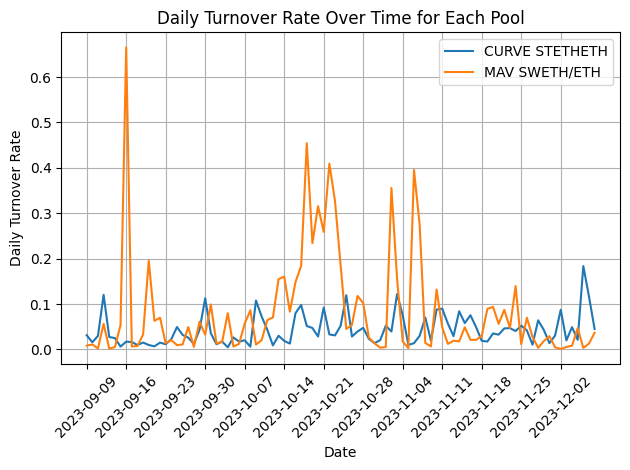

In [4]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator

# Pivot the DataFrame to have pools as columns
pivot_df = df.pivot_table(index='date', columns='pool_name', values='daily_turnover_rate')

# Plot each pool's daily turnover rate over time
for pool in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[pool], label=pool)

# Customize the plot
plt.title('Daily Turnover Rate Over Time for Each Pool')
plt.xlabel('Date')
plt.ylabel('Daily Turnover Rate')
plt.legend()

# Select every 2nd date for display on x-axis
selected_dates = pivot_df.index[::7]
plt.xticks(selected_dates, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

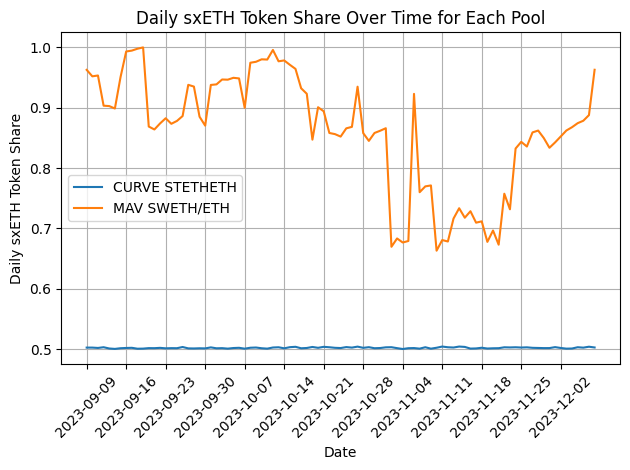

In [5]:
# Pivot the DataFrame to have pools as columns
pivot_df = df.pivot_table(index='date', columns='pool_name', values='daily_staking_rate')

# Plot each pool's daily turnover rate over time
for pool in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[pool], label=pool)

# Customize the plot
plt.title('Daily sxETH Token Share Over Time for Each Pool')
plt.xlabel('Date')
plt.ylabel('Daily sxETH Token Share')
plt.legend()

# Select every 2nd date for display on x-axis
selected_dates = pivot_df.index[::7]
plt.xticks(selected_dates, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

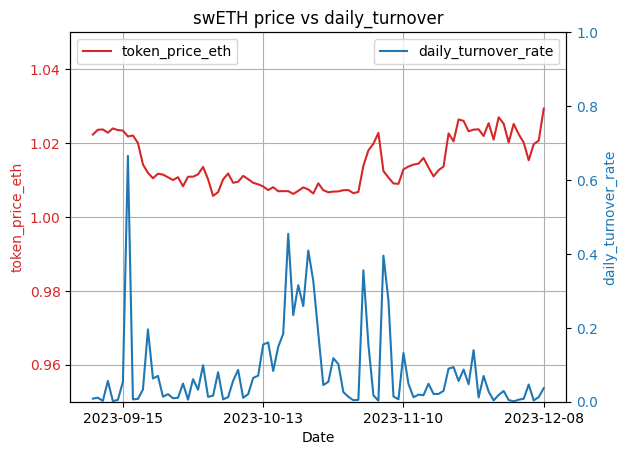

In [8]:
df = df_mav

# Plot the first line with the left y-axis
fig, ax1 = plt.subplots()

label1 = 'token_price_eth'

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(label1, color=color)
ax1.plot(df['date'], df[label1], color=color, label=label1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_ylim(0.95, 1.05)
plt.grid(True)

label2 = 'daily_turnover_rate'

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(label2, color=color)
ax2.plot(df['date'], df[label2], color=color, label=label2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.set_ylim(0, 1)

# Title for the entire plot
plt.title('swETH price vs daily_turnover')
# Select every 2nd date for display on x-axis
selected_dates = df['date'][::28]
plt.xticks(selected_dates, rotation=45)

plt.show()


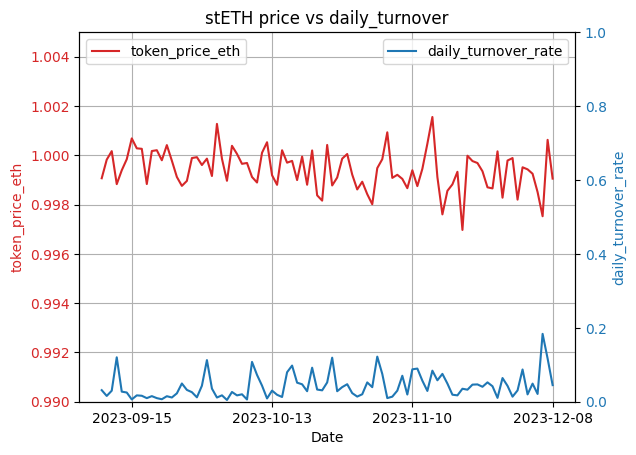

In [10]:
df = df_curve

# Plot the first line with the left y-axis
fig, ax1 = plt.subplots()

label1 = 'token_price_eth'

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(label1, color=color)
ax1.plot(df['date'], df[label1], color=color, label=label1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_ylim(0.990, 1.005)
plt.grid(True)

label2 = 'daily_turnover_rate'

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(label2, color=color)
ax2.plot(df['date'], df[label2], color=color, label=label2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

ax2.set_ylim(0, 1)

# Title for the entire plot
plt.title('stETH price vs daily_turnover')
# Select every 2nd date for display on x-axis
selected_dates = df['date'][::28]
plt.xticks(selected_dates, rotation=45)

plt.show()
